In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from nptdms import TdmsFile
import os

In [2]:
def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }

def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

In [3]:
# Parameters to set

filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2"

offset = 426967933
num_files = 6
traces_per_file = 2

# Data set - 1/29 "5PM2"
# a = 2.726e-6
# v = 51.198e14
# bin = 165 (200M sample rate)

# Found by verifying where the noise cumulative VPSD reaches 4% of signal cumulative VPSD
# bin_num = 165
bin_num = 150
# (V^2/m^2) Found by fitting to PSD
V = 51.198e14
# (Hz) Found where low f noise begins to dominate in the PSD
high_pass = 100


In [4]:
results = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
print(results[0]["args"])

Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 0
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 1
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 2
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 3
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 4
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 5
data_col  X
{'sampling_rate': 200000000.0, 'track_len': 8388608}


SAMPLING RATE IS 200000000.0


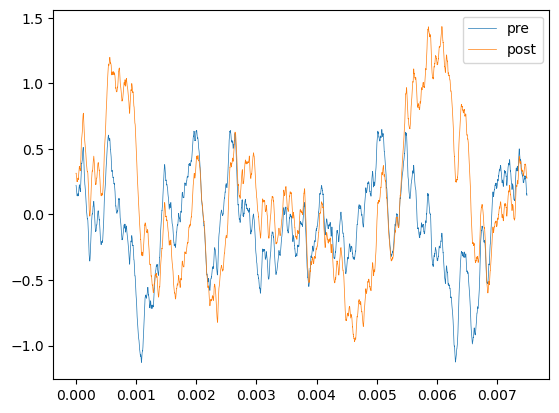

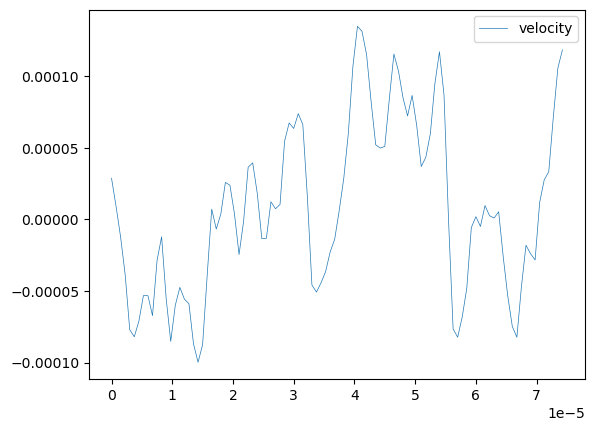

In [5]:
# Bin the data and set the time trace x axis

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces = []
for trace in results:
    series = bin_data(trace["series"], bin_num)
    traces.append(series)

time = np.arange(0, len(traces[0]))
sampling_rate = results[0]['args']['sampling_rate']
print("SAMPLING RATE IS " + str(sampling_rate))
time = time * (bin_num/(sampling_rate))
fs = sampling_rate/bin_num

# Apply the transfer function

# To account for near zero DC transfer we apply tikhonov regularization. We find alpha to be the frequency in which noise (low f) begins to dominate (around 100Hz)

# We will appky the following to the signal S:   U = S/T    -->  U = S*T/(T^2 + L^2)      where U is the underlying signal, S is the raw signal, T is the transfer function and L is some paramter lambda

def transfer_func(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    A = 4000
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + (1/3)*(A)**2)
    RC_high_pass = x_c / (x_c+C)
    return Sallen_key*RC_high_pass

# This number (100Hz) was found by visually inspecting the PSD, observing where the low f noise takes over (100Hz), and choosing lamda to be the magnitude of the transfer function at 100Hz so that the lamda term begins to take over when f > 100 Hz
lda = np.abs(transfer_func(high_pass))
traces_post_transfer = []

for trace in traces:
    # apply the transfer and convert back
    freq_domain_data = scipy.fft.fft(trace)
    frequencies = scipy.fft.fftfreq(len(trace), time[1] - time[0])
    transfer = transfer_func(frequencies)

    freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
    data = np.fft.ifft(freq_domain_data_transfer)

    traces_post_transfer.append(np.real(data))

plt.plot(time[:10000], traces[0][:10000], label = "pre", linewidth=.5)
plt.plot(time[:10000], traces_post_transfer[0][:10000], label = "post", linewidth=.5)
plt.legend()
plt.show()

v_squared = V
v = math.sqrt(v_squared)

traces_post_meter = []
for trace in traces_post_transfer:
    traces_post_meter.append(np.real(trace / v))

# Apply second order finite differences to find velocity traces

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

velocity_traces = []
for trace in traces_post_meter:
    velocity = get_velocity_higher_order(trace, time, 2)
    velocity_traces.append(velocity)

plt.plot(time[:100], velocity_traces[0][:100], label = "velocity", linewidth=.5)
plt.legend()
plt.show()

In [6]:
from tqdm import tqdm
def compute_msd(time_trace, dt):

    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        d_sq = np.square(displacements)
        msd[tau] = np.mean(d_sq)

    return msd, lag_times


TRAP CENTER 0.0
Number of center idx 37160
Number of zero P/V idx 4


100%|██████████| 10000/10000 [00:00<00:00, 117149.51it/s]


TRAP CENTER -6.058457529892714e-26
Number of center idx 38500
Number of zero P/V idx 4


100%|██████████| 10000/10000 [00:00<00:00, 111647.14it/s]


TRAP CENTER 1.8175372589678142e-25
Number of center idx 36479
Number of zero P/V idx 1


100%|██████████| 10000/10000 [00:00<00:00, 103618.07it/s]


TRAP CENTER -2.4233830119570856e-25
Number of center idx 38143
Number of zero P/V idx 3


100%|██████████| 10000/10000 [00:00<00:00, 130685.66it/s]


TRAP CENTER -1.2874222251022017e-25
Number of center idx 35596
Number of zero P/V idx 3


100%|██████████| 10000/10000 [00:00<00:00, 104913.99it/s]


TRAP CENTER 7.573071912365892e-26
Number of center idx 36294
Number of zero P/V idx 2


100%|██████████| 10000/10000 [00:00<00:00, 125785.85it/s]


TRAP CENTER -9.087686294839071e-26
Number of center idx 35179
Number of zero P/V idx 5


100%|██████████| 10000/10000 [00:00<00:00, 116687.37it/s]


TRAP CENTER -5.301150338656125e-26
Number of center idx 35036
Number of zero P/V idx 5


100%|██████████| 10000/10000 [00:00<00:00, 119203.10it/s]


TRAP CENTER 0.0
Number of center idx 35241
Number of zero P/V idx 5


100%|██████████| 10000/10000 [00:00<00:00, 120660.51it/s]


TRAP CENTER -1.8175372589678142e-25
Number of center idx 40623
Number of zero P/V idx 3


100%|██████████| 10000/10000 [00:00<00:00, 136334.51it/s]


TRAP CENTER -3.029228764946357e-26
Number of center idx 38325
Number of zero P/V idx 2


100%|██████████| 10000/10000 [00:00<00:00, 122321.07it/s]


TRAP CENTER 1.2116915059785428e-25
Number of center idx 37529
Number of zero P/V idx 6


100%|██████████| 10000/10000 [00:00<00:00, 104562.99it/s]


Text(0.5, 1.0, 'Initially < 1e-08 pos and < 1e-08 vel')

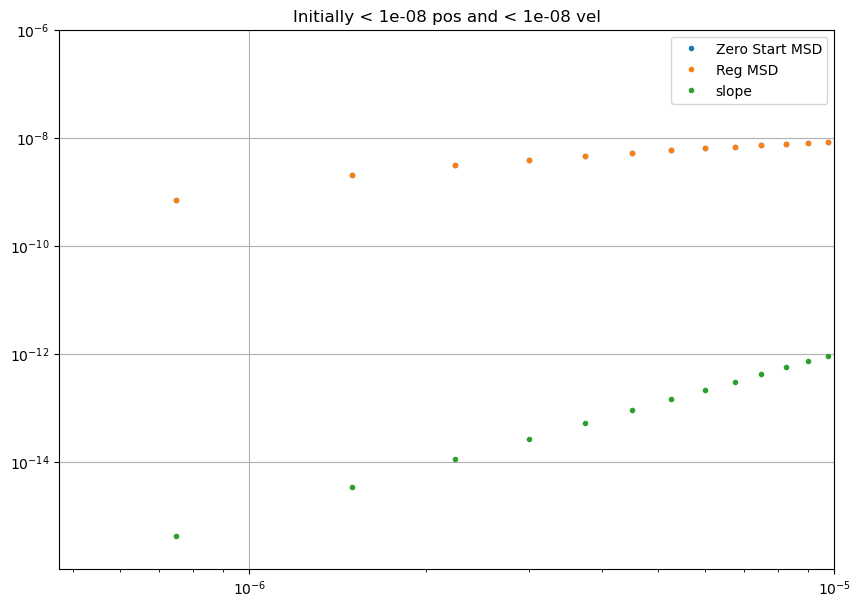

In [7]:
import random

def ordered_random_integers(x, N):
    # Generate x unique random integers between 0 and N
    random_integers = random.sample(range(N + 1), x)

    # Sort them in ascending order
    ordered_integers = sorted(random_integers)

    return ordered_integers

arr_super_msd = []
arr_reg_msd = []
lag_times = 0

pos_tolerance = 1e-8
v_tolerance = 1e-8
track_len = 10000

# print("Number of traces " + str(len(velocity_traces)))
for i in range(len(velocity_traces)):
    trap_center = np.mean(traces_post_meter[i])
    print("TRAP CENTER " + str(trap_center))

    trap_center_indicies = np.where(abs(traces_post_meter[i] - trap_center) < pos_tolerance)[0]
    valid = trap_center_indicies < len(traces_post_meter[i]) - track_len
    trap_center_indicies = trap_center_indicies[valid]

    print("Number of center idx " + str(len(trap_center_indicies)))

    initial_zero_indicies = []
    for j in trap_center_indicies:
        if abs(velocity_traces[i][j])<v_tolerance:
            # plt.plot(traces_post_meter[i][j-10:j+10])
            # plt.axvline(x=10)
            initial_zero_indicies.append(j)

    print("Number of zero P/V idx " + str(len(initial_zero_indicies)))

    #Now make a list where the inx of v_Series are close to zero as well!!!

    # close_to_zero_indices = np.where(abs(v_series) < tolerance)[0]
    # valid = close_to_zero_indices < len(v_series) - track_len
    #
    # close_to_zero_indices = close_to_zero_indices[valid]

    # Pick the same amount of random indicies
    not_close_to_zero_indicies = ordered_random_integers(10*len(initial_zero_indicies), len(velocity_traces[i]) - track_len)

    initially_zero_series = []
    not_initially_zero_series = []

    for j in initial_zero_indicies:
        initially_zero_series.append(velocity_traces[i][j:j+track_len])
    for j in not_close_to_zero_indicies:
        not_initially_zero_series.append(velocity_traces[i][j:j+track_len])

    # plt.title("Positions")
    # # Draw vertical lines where values are close to zero
    # for index in close_to_zero_indices:
    #     plt.axvline(x=index*index_mult, color='red', linestyle='-', linewidth=0.1)
    # plt.show()

    zero_start_msd = []
    reg_msd = []

    for series in initially_zero_series:
        msd, lag_times = compute_msd(series, bin_num/sampling_rate)
        zero_start_msd.append(msd)
    for series in not_initially_zero_series:
        msd, lag_times = compute_msd(series,  bin_num/sampling_rate)
        reg_msd.append(msd)

    # Convert lists to NumPy arrays before computing the mean
    zero_start_msd = np.array(zero_start_msd)
    reg_msd = np.array(reg_msd)
    zero_mean_msd = np.mean(zero_start_msd, axis=0)
    reg_mean_msd = np.mean(reg_msd, axis=0)

    arr_super_msd.append(zero_mean_msd)
    arr_reg_msd.append(reg_mean_msd)
    #
    # plt.figure(figsize=(10, 7))
    # plt.plot(lag_times, zero_mean_msd, ".", label='Zero Start MSD')
    # plt.plot(lag_times, reg_mean_msd, ".", label='Reg MSD')
    # y = (lag_times**2)*1e3
    # plt.plot(lag_times, y, ".", label='slope')
    # plt.xscale("log")
    # plt.yscale("log")
    # plt.xlim(right=1e-5)
    # plt.ylim(top=1e-6)
    # plt.legend()
    # plt.grid()
    # plt.title("Initially < " + str(pos_tolerance) + " pos and < " + str(v_tolerance) + " vel")

super = np.mean(arr_super_msd, axis=0)
reg = np.mean(arr_reg_msd, axis=0)
plt.figure(figsize=(10, 7))
plt.plot(lag_times, super, ".", label='Zero Start MSD')
plt.plot(lag_times, reg, ".", label='Reg MSD')
y = (lag_times**3)*1e3
plt.plot(lag_times, y, ".", label='slope')
plt.xscale("log")
plt.yscale("log")
plt.xlim(right=1e-5)
plt.ylim(top=1e-6)
plt.legend()
plt.grid()
plt.title("Initially < " + str(pos_tolerance) + " pos and < " + str(v_tolerance) + " vel")


Text(0.5, 1.0, 'Initially < 1e-08 pos and < 1e-08 vel')

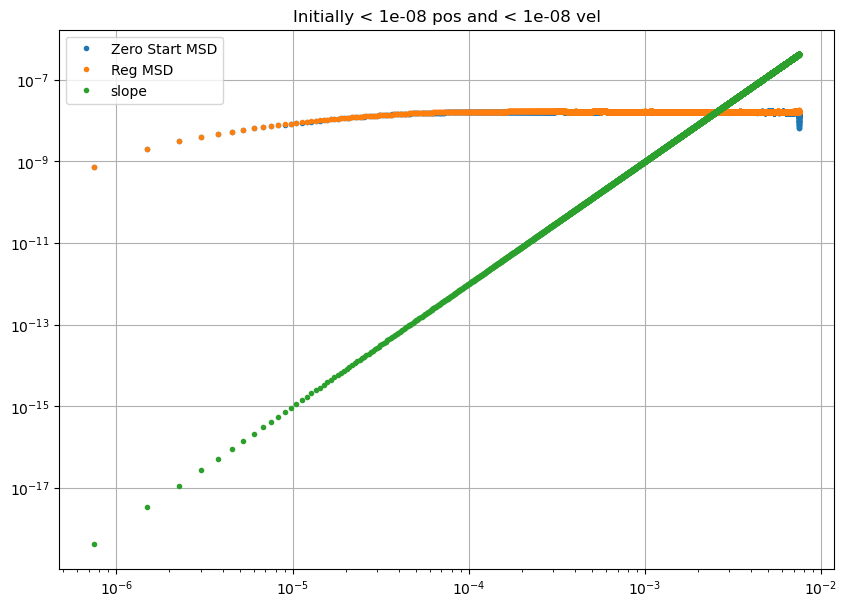

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(lag_times, super, ".", label='Zero Start MSD')
plt.plot(lag_times, reg, ".", label='Reg MSD')
y = (lag_times**3)
plt.plot(lag_times, y, ".", label='slope')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Initially < " + str(pos_tolerance) + " pos and < " + str(v_tolerance) + " vel")